In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import os

from pclib.nn.models import FCPCN
from pclib.optim.train import train
from pclib.optim.eval import track_vfe, accuracy
from pclib.utils.functional import format_y, identity, shrinkage
from pclib.utils.customdataset import PreloadedDataset

from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

In [2]:
seed = 42
# For reproducibility
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

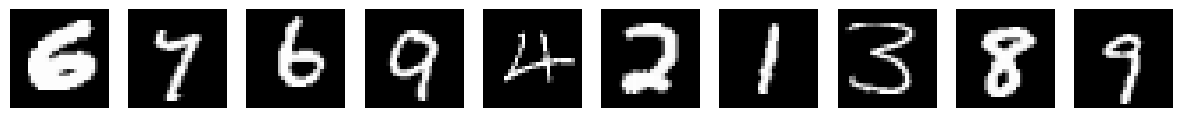

Max value:  tensor(1., device='cuda:0')
Min value:  tensor(0., device='cuda:0')


In [3]:
torch.manual_seed(seed)

# Scale img transform
class Scale(object):
    def __init__(self, scale_factor):
        self.scale_factor = scale_factor

    def __call__(self, img):
        return img * self.scale_factor + 0.5 * (1 - self.scale_factor)

# Inverse Logistic Sigmoid Transform
class InvLogit(object):
    def __call__(self, x):
        return torch.log(x / (1 - x))

train_transform = transforms.Compose([
    transforms.ToTensor(),
    # Scale(0.9),
    # InvLogit(),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
    # transforms.Normalize((0.1307,), (0.3081,)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    # Scale(0.9),
    # InvLogit(),
    # transforms.Normalize((0.1307,), (0.3081,)),
])

dataset = datasets.MNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())

VAL_RATIO = 0.2
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, train_transform, device)
val_dataset = PreloadedDataset.from_dataset(val_dataset, val_transform, device)
INPUT_SHAPE = 784
NUM_CLASSES = 10

# Show some images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

# print max min values
print('Max value: ', train_dataset.transformed_images.max())
print('Min value: ', train_dataset.transformed_images.min())

In [4]:
H_DIM = 200
Z_DIM = 20
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(INPUT_SHAPE, 200),
            nn.ReLU(),
            nn.Linear(200, H_DIM),
            nn.ReLU(),
        )

        self.mu = nn.Linear(H_DIM, Z_DIM)
        self.logvar = nn.Linear(H_DIM, Z_DIM)
        self.z2hidden = nn.Linear(Z_DIM, H_DIM)

        self.decoder = nn.Sequential(
            nn.Linear(H_DIM, 200),
            nn.ReLU(),
            nn.Linear(200, INPUT_SHAPE),
            nn.Sigmoid()
        )
        self.register_buffer('epochs_trained', torch.tensor(0, dtype=torch.long))
        self.register_buffer('min_val_loss', torch.tensor(float('inf')))
    
    def inc_epochs(self):
        self.epochs_trained += 1
    
    def is_best(self, val_loss):
        if val_loss < self.min_val_loss:
            self.min_val_loss = val_loss
            return True
        return False
    
    def encode(self, x):
        h = self.encoder(x)
        return self.mu(h), self.logvar(h)
    
    def reparameterize(self, mu, logvar):     
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(self.z2hidden(z))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def sample(self, n):
        z = torch.randn(n, Z_DIM).to(device)
        return self.decode(z)
    
    def loss(self, x_hat, x, mu, logvar):
        BCE = F.binary_cross_entropy(x_hat, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD

In [26]:
def train(
        model,
        log_dir,
        train_dataset,
        val_dataset,
        num_epochs,
        batch_size,
        optimiser,
        stats,
):
    if log_dir is not None:
        writer = SummaryWriter(log_dir)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    if stats is None:
        stats = {
            'train_loss': [],
            'val_loss': [],
        }

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = torch.zeros(len(train_loader)).to(device)
        loop = tqdm(enumerate(train_loader), leave=False, desc=f'Epoch [{epoch + 1}/{num_epochs}]')
        if epoch > 0:
            loop.set_postfix({'train_loss': stats['train_loss'][-1], 'val_loss': stats['val_loss'][-1]})
        for i, (x, _) in loop:
            x = x.view(-1, INPUT_SHAPE)
            x_hat, mu, logvar = model(x)
            loss = model.loss(x_hat, x, mu, logvar)
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            epoch_train_loss[i] = loss.item()
        stats['train_loss'].append(epoch_train_loss.sum().item() / len(train_dataset))
        
        model.eval()
        with torch.no_grad():
            epoch_val_loss = torch.zeros(len(val_loader)).to(device)
            for i, (x, _) in enumerate(val_loader):
                x = x.view(-1, INPUT_SHAPE)
                x_hat, mu, logvar = model(x)
                val_loss = model.loss(x_hat, x, mu, logvar)
                epoch_val_loss[i] = val_loss.item()
            stats['val_loss'].append(epoch_val_loss.sum().item() / len(val_dataset))

            should_update = model.is_best(epoch_val_loss.sum().detach() / len(val_dataset))
            model.inc_epochs()
        
        if log_dir is not None:
            writer.add_scalar('Loss/train', stats['train_loss'][-1], epoch)
            writer.add_scalar('Loss/val', stats['val_loss'][-1], epoch)
            
    return stats

In [27]:
torch.manual_seed(42)
log_dir = f"examples/mnist/out/logs/baseline/VAE"
model = VAE().to(device)
optimiser = torch.optim.AdamW(model.parameters(), lr=0.001)
stats = None

In [28]:
log_dir = None
stats = train(
    model,
    log_dir,
    train_dataset,
    val_dataset,
    num_epochs=30,
    batch_size=32,
    optimiser=optimiser,
    stats=stats,
)

Epoch [11/30]: 755it [00:01, 603.49it/s, train_loss=110, val_loss=110] 

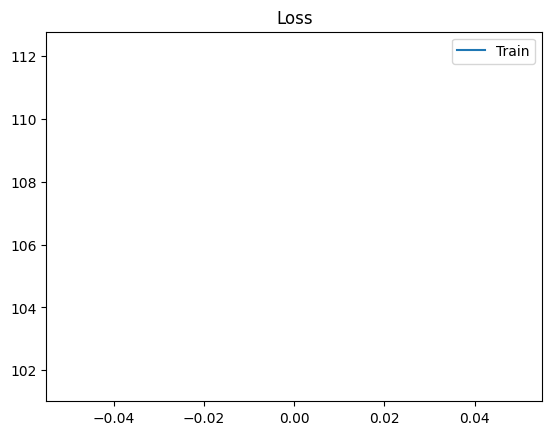

In [ ]:
plt.plot(stats['train_loss'], label='Train')
# plt.plot(stats['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()